# LIB

In [ ]:
!pip install catboost 
!pip install category_encoders
!pip install optuna

In [2]:
import pandas as pd
import numpy as np
import warnings, random
warnings.filterwarnings(action='ignore')
import matplotlib.pyplot as plt
import math
import seaborn as sns

from sklearn.metrics import log_loss
from sklearn.preprocessing import OneHotEncoder,StandardScaler,PowerTransformer,LabelEncoder
from category_encoders.ordinal import OrdinalEncoder
from sklearn.model_selection import StratifiedKFold

from sklearn.cluster import KMeans
from catboost import CatBoostClassifier, Pool

from sklearn.model_selection import StratifiedKFold,train_test_split
import optuna
from optuna.samplers import TPESampler
from sklearn import datasets
import sklearn.datasets
import sklearn.metrics
from sklearn.model_selection import train_test_split
import xgboost as xgb
#import psutil
import gc
import time

from tensorflow.keras.utils import to_categorical
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE

# Load Data

In [3]:
from google.colab import drive
drive.mount('/content/drive')
path = '/content/drive/MyDrive/cp1/'
train = pd.read_csv(path + 'train2.csv')
test = pd.read_csv(path + 'test2.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# train = pd.read_csv('./train2.csv')
# test = pd.read_csv('./test2.csv')

In [4]:
train.head()

,Unnamed: 0,id,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,...,email,occyp_type,family_size,begin_month,credit,YEARS_BIRTH,Age_group,YEARS_EMPLOYED,EMPLOYED_group,income_avg
0,0,F138994709202500,F,N,N,0,3948.75,Commercial associate,Higher education,Married,...,0,NAN,2.0,6.0,1.0,39,30,12,10~15,1974.375
1,1,F113801540247500,F,N,Y,1,4826.25,Commercial associate,Secondary / secondary special,Civil marriage,...,1,Laborers,3.0,5.0,1.0,32,30,4,0~5,1608.750
2,2,M190874434450000,M,Y,Y,0,8775.00,Working,Higher education,Married,...,0,Managers,2.0,22.0,2.0,53,50,12,10~15,4387.500
3,3,F150882092202500,F,N,Y,0,3948.75,Commercial associate,Secondary / secondary special,Married,...,0,Sales staff,2.0,37.0,0.0,42,40,5,5~10,1974.375
4,4,F150372105157500,F,Y,Y,0,3071.25,State servant,Higher education,Married,...,0,Managers,2.0,26.0,2.0,42,40,5,5~10,1535.625


In [5]:
train.drop(['Unnamed: 0'],axis=1,inplace=True)
train.head()

,id,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,...,email,occyp_type,family_size,begin_month,credit,YEARS_BIRTH,Age_group,YEARS_EMPLOYED,EMPLOYED_group,income_avg
0,F138994709202500,F,N,N,0,3948.75,Commercial associate,Higher education,Married,Municipal apartment,...,0,NAN,2.0,6.0,1.0,39,30,12,10~15,1974.375
1,F113801540247500,F,N,Y,1,4826.25,Commercial associate,Secondary / secondary special,Civil marriage,House / apartment,...,1,Laborers,3.0,5.0,1.0,32,30,4,0~5,1608.750
2,M190874434450000,M,Y,Y,0,8775.00,Working,Higher education,Married,House / apartment,...,0,Managers,2.0,22.0,2.0,53,50,12,10~15,4387.500
3,F150882092202500,F,N,Y,0,3948.75,Commercial associate,Secondary / secondary special,Married,House / apartment,...,0,Sales staff,2.0,37.0,0.0,42,40,5,5~10,1974.375
4,F150372105157500,F,Y,Y,0,3071.25,State servant,Higher education,Married,House / apartment,...,0,Managers,2.0,26.0,2.0,42,40,5,5~10,1535.625


In [6]:
test.drop(['Unnamed: 0'],axis=1,inplace=True)
test.head()

,id,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,...,phone,email,occyp_type,family_size,begin_month,YEARS_BIRTH,Age_group,YEARS_EMPLOYED,EMPLOYED_group,income_avg
0,M219900112500,M,Y,N,0,2193.750,Pensioner,Secondary / secondary special,Civil marriage,House / apartment,...,1,0,No work experience,2.0,60.0,61,60,No work experience,0~5,1096.875
1,F189648671135000,F,N,Y,0,2632.500,State servant,Higher education,Married,House / apartment,...,1,0,Core staff,2.0,36.0,52,50,23,20~25,1316.250
2,F1588721769372,F,N,Y,0,1352.754,Working,Secondary / secondary special,Married,House / apartment,...,1,0,Laborers,2.0,40.0,44,40,0,0~5,676.377
3,M192702531112500,M,Y,N,0,2193.750,Commercial associate,Secondary / secondary special,Married,House / apartment,...,0,0,Drivers,2.0,41.0,53,50,6,5~10,1096.875
4,F178229385225000,F,Y,Y,0,4387.500,State servant,Higher education,Married,House / apartment,...,0,0,Managers,2.0,8.0,49,40,25,25~30,2193.750


In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26440 entries, 0 to 26439
Data columns (total 22 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              26440 non-null  object 
 1   gender          26440 non-null  object 
 2   car             26440 non-null  object 
 3   reality         26440 non-null  object 
 4   child_num       26440 non-null  int64  
 5   income_total    26440 non-null  float64
 6   income_type     26440 non-null  object 
 7   edu_type        26440 non-null  object 
 8   family_type     26440 non-null  object 
 9   house_type      26440 non-null  object 
 10  work_phone      26440 non-null  int64  
 11  phone           26440 non-null  int64  
 12  email           26440 non-null  int64  
 13  occyp_type      26440 non-null  object 
 14  family_size     26440 non-null  float64
 15  begin_month     26440 non-null  float64
 16  credit          26440 non-null  float64
 17  YEARS_BIRTH     26440 non-null 

# category / numerical columns

In [8]:
drop_c=['work_phone','phone','email','id','YEARS_EMPLOYED']
train.drop(drop_c,axis=1,inplace=True)
test.drop(drop_c,axis=1,inplace=True)

In [9]:
numerical_feats = train.dtypes[train.dtypes != "object"].index.tolist()
numerical_feats.remove('credit')
print("Number of Numerical features: ", len(numerical_feats))

categorical_feats = train.dtypes[train.dtypes == "object"].index.tolist()
print("Number of Categorical features: ", len(categorical_feats))

Number of Numerical features:  7
Number of Categorical features:  9


In [10]:
train.columns

Index(['gender', 'car', 'reality', 'child_num', 'income_total', 'income_type',
       'edu_type', 'family_type', 'house_type', 'occyp_type', 'family_size',
       'begin_month', 'credit', 'YEARS_BIRTH', 'Age_group', 'EMPLOYED_group',
       'income_avg'],
      dtype='object')

In [11]:
numerical_feats

['child_num',
 'income_total',
 'family_size',
 'begin_month',
 'YEARS_BIRTH',
 'Age_group',
 'income_avg']

In [12]:
categorical_feats

['gender',
 'car',
 'reality',
 'income_type',
 'edu_type',
 'family_type',
 'house_type',
 'occyp_type',
 'EMPLOYED_group']

In [13]:
list(train['EMPLOYED_group'].value_counts().index)

['0~5', '5~10', '10~15', '15~20', '20~25', '25~30', '30~35', '35~40', '40~']

In [14]:
for i in categorical_feats:
    print(f'{i} 컬럼 항목은 : {list(train[i].value_counts().index)}')

gender 컬럼 항목은 : ['F', 'M']
car 컬럼 항목은 : ['N', 'Y']
reality 컬럼 항목은 : ['Y', 'N']
income_type 컬럼 항목은 : ['Working', 'Commercial associate', 'Pensioner', 'State servant', 'Student']
edu_type 컬럼 항목은 : ['Secondary / secondary special', 'Higher education', 'Incomplete higher', 'Lower secondary', 'Academic degree']
family_type 컬럼 항목은 : ['Married', 'Single / not married', 'Civil marriage', 'Separated', 'Widow']
house_type 컬럼 항목은 : ['House / apartment', 'With parents', 'Municipal apartment', 'Rented apartment', 'Office apartment', 'Co-op apartment']
occyp_type 컬럼 항목은 : ['Laborers', 'No work experience', 'NAN', 'Core staff', 'Sales staff', 'Managers', 'Drivers', 'High skill tech staff', 'Accountants', 'Medicine staff', 'Cooking staff', 'Security staff', 'Cleaning staff', 'Private service staff', 'Low-skill Laborers', 'Waiters/barmen staff', 'Secretaries', 'Realty agents', 'HR staff', 'IT staff']
EMPLOYED_group 컬럼 항목은 : ['0~5', '5~10', '10~15', '15~20', '20~25', '25~30', '30~35', '35~40', '40~']


In [15]:
# 수치형 컬럼

# 'child_num' = 정수
# 'income_total' = 만원단위
# 'family_size' = 정수
# 'begin_month' = 달단위
# 'YEARS_BIRTH' = 나이
# 'income_avg' = income_total / famliy_size
# 'Age_group' = 
# def change_category(num):
#     return (math.trunc(num)//10)*10

# train['Age_group']=train['YEARS_BIRTH'].apply(change_category)
# test['Age_group']=test['YEARS_BIRTH'].apply(change_category)

# MODELING

In [16]:
seed = 42
n_fold_list =14
n_class = 3

target = 'credit'
X = train.drop(target, axis=1)
y = train[target]
X_test = test

## CatBoostClassifier

In [17]:
print('***',n_fold_list,'***')

skfold = StratifiedKFold(n_splits=n_fold_list, shuffle=True, random_state=seed)
folds=[]
for train_idx, valid_idx in skfold.split(X, y):
        folds.append((train_idx, valid_idx))

cat_pred = np.zeros((X.shape[0], n_class))
cat_pred_test = np.zeros((X_test.shape[0], n_class))

for fold in range(n_fold_list):
    print(f'\n----------------- Fold {fold} -----------------\n')
    train_idx, valid_idx = folds[fold]
    X_train, X_valid, y_train, y_valid = X.iloc[train_idx], X.iloc[valid_idx], y[train_idx], y[valid_idx]
    train_data = Pool(data=X_train, label=y_train, cat_features=cat_cols)
    valid_data = Pool(data=X_valid, label=y_valid, cat_features=cat_cols)

    model_cat = CatBoostClassifier(n_estimators=3000, max_depth=8, random_seed=seed, learning_rate=0.04, 
                                bootstrap_type ='Bernoulli',auto_class_weights='SqrtBalanced',task_type='GPU')
    model_cat.fit(train_data, eval_set=valid_data, use_best_model=True, early_stopping_rounds=100, verbose=100)

    cat_pred[valid_idx] = model_cat.predict_proba(X_valid)
    cat_pred_test += model_cat.predict_proba(X_test) / n_fold_list
    print(f'CV Log Loss Score: {log_loss(y_valid, cat_pred[valid_idx]):.6f}')
    
print(f'\t<*><*><*><*><*><*>Log Loss: {log_loss(y, cat_pred):.6f}<*><*><*><*><*><*>\n\n\n\n')

*** 14 ***

----------------- Fold 0 -----------------

0:	learn: 1.0887115	test: 1.0887016	best: 1.0887016 (0)	total: 27.2ms	remaining: 1m 21s
100:	learn: 0.9328265	test: 0.9493508	best: 0.9493508 (100)	total: 1.6s	remaining: 45.9s
200:	learn: 0.8974180	test: 0.9388996	best: 0.9388254 (197)	total: 3.31s	remaining: 46.1s
300:	learn: 0.8600818	test: 0.9244740	best: 0.9244740 (300)	total: 5.36s	remaining: 48.1s
400:	learn: 0.8254684	test: 0.9140260	best: 0.9140260 (400)	total: 7.05s	remaining: 45.7s
500:	learn: 0.7980714	test: 0.9090989	best: 0.9090989 (500)	total: 9s	remaining: 44.9s
600:	learn: 0.7727274	test: 0.9036125	best: 0.9035119 (598)	total: 11.3s	remaining: 44.9s
700:	learn: 0.7483058	test: 0.8998376	best: 0.8998376 (700)	total: 13.6s	remaining: 44.6s
800:	learn: 0.7263282	test: 0.8957453	best: 0.8957164 (793)	total: 15.7s	remaining: 43.1s
900:	learn: 0.7039057	test: 0.8928013	best: 0.8928013 (900)	total: 17.4s	remaining: 40.6s
1000:	learn: 0.6829530	test: 0.8907170	best: 0.890

In [18]:
def plot_feature_importance(importance,names,model_type):
    
    feature_importance = np.array(importance)
    feature_names = np.array(names)
    
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)
    
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    plt.figure(figsize=(10,8))

    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])

    plt.title(model_type + ' Feature Importance')
    plt.xlabel('Feature Importance')
    plt.ylabel('Feature Names')

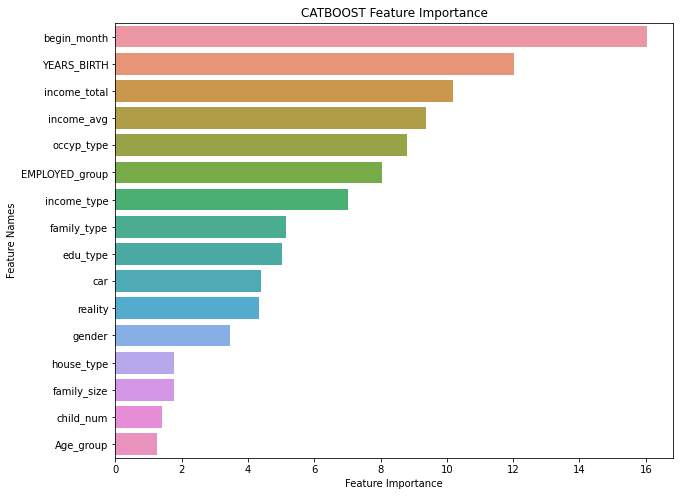

In [19]:
plot_feature_importance(model_cat.get_feature_importance(),X_test.columns,'CATBOOST')

In [20]:
model_cat.save_model('cat_model')

model=CatBoostClassifier()

model.load_model('cat_model')

## XGboost

### categorical features OrdinalEncoder

In [21]:
train.head()

,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,occyp_type,family_size,begin_month,credit,YEARS_BIRTH,Age_group,EMPLOYED_group,income_avg
0,F,N,N,0,3948.75,Commercial associate,Higher education,Married,Municipal apartment,NAN,2.0,6.0,1.0,39,30,10~15,1974.375
1,F,N,Y,1,4826.25,Commercial associate,Secondary / secondary special,Civil marriage,House / apartment,Laborers,3.0,5.0,1.0,32,30,0~5,1608.750
2,M,Y,Y,0,8775.00,Working,Higher education,Married,House / apartment,Managers,2.0,22.0,2.0,53,50,10~15,4387.500
3,F,N,Y,0,3948.75,Commercial associate,Secondary / secondary special,Married,House / apartment,Sales staff,2.0,37.0,0.0,42,40,5~10,1974.375
4,F,Y,Y,0,3071.25,State servant,Higher education,Married,House / apartment,Managers,2.0,26.0,2.0,42,40,5~10,1535.625


In [22]:
encoder = OrdinalEncoder(categorical_feats)
train[categorical_feats] = encoder.fit_transform(train[categorical_feats], train['credit'])
test[categorical_feats] = encoder.transform(test[categorical_feats])

In [23]:
target = 'credit'
X = train.drop(target, axis=1)
y = train[target]
X_test = test

X_train, X_valid, y_train, y_valid = train_test_split(X,y,test_size=0.2)

In [24]:
from sklearn.utils import class_weight
classes_weights = class_weight.compute_sample_weight(
    class_weight='balanced',
    y=y
)

### XGBoost Optuna

In [25]:
def objective(trial):
    
    params = {
        "objective": "multi:softprob",
        "eval_metric":'mlogloss',
        "booster": 'gbtree',
        'tree_method':'gpu_hist', 'predictor':'gpu_predictor', 'gpu_id': 0, # GPU 사용시
        #"tree_method": 'exact', 'gpu_id': -1,  # CPU 사용시
        "verbosity": 0,
        'num_class':3,
        "max_depth": trial.suggest_int("max_depth", 4, 10),
        "learning_rate": trial.suggest_uniform('learning_rate', 0.0001, 0.99),
        'n_estimators': trial.suggest_int("n_estimators", 1000, 10000, step=100),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.5, 1.0),
        "colsample_bynode": trial.suggest_float("colsample_bynode", 0.5, 1.0),
        "reg_lambda": trial.suggest_loguniform("reg_lambda", 1e-2, 1),
        "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-2, 1),
        'subsample': trial.suggest_discrete_uniform('subsample', 0.6, 1.0, 0.05),     
        'min_child_weight': trial.suggest_int('min_child_weight', 2, 15),
        "gamma": trial.suggest_float("gamma", 0.1, 1.0, log=True),
        # 'num_parallel_tree': trial.suggest_int("num_parallel_tree", 1, 500) 추가하면 느려짐.
    }


    model = xgb.XGBClassifier(**params,sample_weight=classes_weights, random_state = 42, enable_categorical=False)

    bst = model.fit(X_train, y_train,eval_set=[(X_valid,y_valid)], early_stopping_rounds=50, verbose=False)
    preds = bst.predict(X_valid)
    pred_labels = np.rint(preds)
    accuracy = sklearn.metrics.accuracy_score(y_valid, pred_labels)
    return accuracy

In [26]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=30)
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)

[I 2022-07-05 08:09:39,951] A new study created in memory with name: no-name-1853ebf3-2323-4299-a948-363c149d6881
[I 2022-07-05 08:10:02,966] Trial 0 finished with value: 0.708963691376702 and parameters: {'max_depth': 10, 'learning_rate': 0.03750086876918411, 'n_estimators': 7000, 'colsample_bytree': 0.9187376456579042, 'colsample_bylevel': 0.7892096919201275, 'colsample_bynode': 0.5731991653985407, 'reg_lambda': 0.012712049994415326, 'reg_alpha': 0.03465627307678904, 'subsample': 0.95, 'min_child_weight': 13, 'gamma': 0.47043948422454795}. Best is trial 0 with value: 0.708963691376702.
[I 2022-07-05 08:10:05,909] Trial 1 finished with value: 0.6978063540090772 and parameters: {'max_depth': 10, 'learning_rate': 0.9186648046760498, 'n_estimators': 3000, 'colsample_bytree': 0.5903630531083308, 'colsample_bylevel': 0.635370696634696, 'colsample_bynode': 0.6559552032088541, 'reg_lambda': 0.03794305765304712, 'reg_alpha': 0.12048594520817983, 'subsample': 0.7, 'min_child_weight': 4, 'gamma

Number of finished trials: 30
Best trial: {'max_depth': 8, 'learning_rate': 0.7910445971627705, 'n_estimators': 7900, 'colsample_bytree': 0.6947765828994363, 'colsample_bylevel': 0.8655811657857022, 'colsample_bynode': 0.7922743010811576, 'reg_lambda': 0.06328895768478249, 'reg_alpha': 0.016085845319291234, 'subsample': 0.8, 'min_child_weight': 8, 'gamma': 0.24151482858900009}


### XGBModeling

In [27]:
xgb_params=study.best_trial.params

In [28]:
print('***',n_fold_list,'***')

skfold = StratifiedKFold(n_splits=n_fold_list, shuffle=True, random_state=seed)
folds=[]
for train_idx, valid_idx in skfold.split(X, y):
        folds.append((train_idx, valid_idx))

cat_pred = np.zeros((X.shape[0], n_class))
cat_pred_test = np.zeros((X_test.shape[0], n_class))

for fold in range(n_fold_list):
    print(f'\n----------------- Fold {fold} -----------------\n')
    train_idx, valid_idx = folds[fold]
    X_train, X_valid, y_train, y_valid = X.iloc[train_idx], X.iloc[valid_idx], y[train_idx], y[valid_idx]
    evals=[(X_valid,y_valid)]
    model_cat = xgb.XGBClassifier(**xgb_params,sample_weight=classes_weights,random_state=seed)
    model_cat.fit(X_train,y_train,eval_set=evals, early_stopping_rounds=100, verbose=100)

    cat_pred[valid_idx] = model_cat.predict_proba(X_valid)
    cat_pred_test += model_cat.predict_proba(X_test) / n_fold_list
    print(f'CV Log Loss Score: {log_loss(y_valid, cat_pred[valid_idx]):.6f}')
    
print(f'\t<*><*><*><*><*><*>Log Loss: {log_loss(y, cat_pred):.6f}<*><*><*><*><*><*>\n\n\n\n')

*** 14 ***

----------------- Fold 0 -----------------

[0]	validation_0-merror:0.314981
Will train until validation_0-merror hasn't improved in 100 rounds.
[100]	validation_0-merror:0.309688
Stopping. Best iteration:
[44]	validation_0-merror:0.291159

CV Log Loss Score: 0.762778

----------------- Fold 1 -----------------

[0]	validation_0-merror:0.320275
Will train until validation_0-merror hasn't improved in 100 rounds.
[100]	validation_0-merror:0.292218
Stopping. Best iteration:
[94]	validation_0-merror:0.285866

CV Log Loss Score: 0.810435

----------------- Fold 2 -----------------

[0]	validation_0-merror:0.320275
Will train until validation_0-merror hasn't improved in 100 rounds.
[100]	validation_0-merror:0.313923
Stopping. Best iteration:
[25]	validation_0-merror:0.293277

CV Log Loss Score: 0.766228

----------------- Fold 3 -----------------

[0]	validation_0-merror:0.320805
Will train until validation_0-merror hasn't improved in 100 rounds.
[100]	validation_0-merror:0.30439

In [29]:
def plot_feature_importance(importance,names,model_type):
    
    feature_importance = np.array(importance)
    feature_names = np.array(names)
    
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)
    
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    plt.figure(figsize=(10,8))

    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])

    plt.title(model_type + ' Feature Importance')
    plt.xlabel('Feature Importance')
    plt.ylabel('Feature Names')

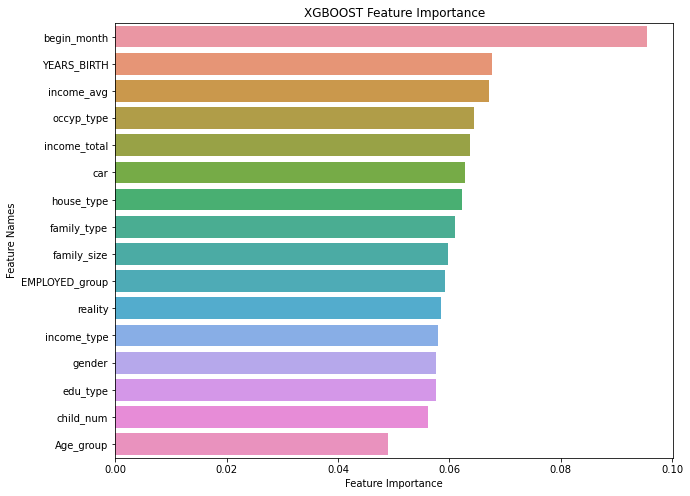

In [30]:
plot_feature_importance(model_cat.feature_importances_,X_test.columns,'XGBOOST')

## Randomforest

### RandomForest Optuna

In [31]:
def objective(trial):
    
    params = {
            'n_estimators': trial.suggest_int('n_estimators', 50, 1000),
            'max_depth': trial.suggest_int('max_depth', 1, 50),
            #'min_samples_split': trial.suggest_int('min_samples_split', 1, 150),
            'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 60),
            'bootstrap' : trial.suggest_categorical('bootstrap',['True','False']),
            'max_features' :trial.suggest_categorical('max_features', ['auto', 'sqrt','log2']),
            'max_leaf_nodes' : trial.suggest_int('max_leaf_nodes', 1, 10000)
        }

    model = RandomForestClassifier(**params, random_state = 42,class_weight='balanced')

    bst = model.fit(X_train, y_train)
    preds = bst.predict(X_valid)
    pred_labels = np.rint(preds)
    accuracy = sklearn.metrics.accuracy_score(y_valid, pred_labels)
    return accuracy

In [32]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=30)
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)

[I 2022-07-05 08:13:49,387] A new study created in memory with name: no-name-e64b4fee-586a-48a8-bab1-086c8a70e0d7
[I 2022-07-05 08:13:51,787] Trial 0 finished with value: 0.625 and parameters: {'n_estimators': 144, 'max_depth': 31, 'min_samples_leaf': 57, 'bootstrap': 'False', 'max_features': 'auto', 'max_leaf_nodes': 4988}. Best is trial 0 with value: 0.625.
[I 2022-07-05 08:13:53,669] Trial 1 finished with value: 0.635593220338983 and parameters: {'n_estimators': 109, 'max_depth': 50, 'min_samples_leaf': 44, 'bootstrap': 'True', 'max_features': 'auto', 'max_leaf_nodes': 9407}. Best is trial 0 with value: 0.625.
[I 2022-07-05 08:13:57,264] Trial 2 finished with value: 0.659427966101695 and parameters: {'n_estimators': 622, 'max_depth': 2, 'min_samples_leaf': 16, 'bootstrap': 'True', 'max_features': 'auto', 'max_leaf_nodes': 9074}. Best is trial 0 with value: 0.625.
[I 2022-07-05 08:14:03,113] Trial 3 finished with value: 0.6292372881355932 and parameters: {'n_estimators': 359, 'max_de

Number of finished trials: 30
Best trial: {'n_estimators': 405, 'max_depth': 19, 'min_samples_leaf': 60, 'bootstrap': 'False', 'max_features': 'auto', 'max_leaf_nodes': 6465}


### RFModeling

In [33]:
randomforest_params=study.best_trial.params

In [34]:
print('***',n_fold_list,'***')

skfold = StratifiedKFold(n_splits=n_fold_list, shuffle=True, random_state=seed)
folds=[]
for train_idx, valid_idx in skfold.split(X, y):
        folds.append((train_idx, valid_idx))

cat_pred = np.zeros((X.shape[0], n_class))
cat_pred_test = np.zeros((X_test.shape[0], n_class))
for fold in range(n_fold_list):
    print(f'\n----------------- Fold {fold} -----------------\n')
    train_idx, valid_idx = folds[fold]
    X_train, X_valid, y_train, y_valid = X.iloc[train_idx], X.iloc[valid_idx], y[train_idx], y[valid_idx]
    #evals=[(X_valid,y_valid)]
    model_cat = RandomForestClassifier(**randomforest_params,class_weight='balanced',random_state=seed)
    model_cat.fit(X_train,y_train)

    cat_pred[valid_idx] = model_cat.predict_proba(X_valid)
    cat_pred_test += model_cat.predict_proba(X_test) / n_fold_list
    print(f'CV Log Loss Score: {log_loss(y_valid, cat_pred[valid_idx]):.6f}')
    
print(f'\t<*><*><*><*><*><*>Log Loss: {log_loss(y, cat_pred):.6f}<*><*><*><*><*><*>\n\n\n\n')

*** 14 ***

----------------- Fold 0 -----------------

CV Log Loss Score: 0.977214

----------------- Fold 1 -----------------

CV Log Loss Score: 0.975569

----------------- Fold 2 -----------------

CV Log Loss Score: 0.980647

----------------- Fold 3 -----------------

CV Log Loss Score: 0.977031

----------------- Fold 4 -----------------

CV Log Loss Score: 0.981381

----------------- Fold 5 -----------------

CV Log Loss Score: 0.985206

----------------- Fold 6 -----------------

CV Log Loss Score: 0.984975

----------------- Fold 7 -----------------

CV Log Loss Score: 0.993245

----------------- Fold 8 -----------------

CV Log Loss Score: 0.973812

----------------- Fold 9 -----------------

CV Log Loss Score: 0.986729

----------------- Fold 10 -----------------

CV Log Loss Score: 0.980780

----------------- Fold 11 -----------------

CV Log Loss Score: 0.983439

----------------- Fold 12 -----------------

CV Log Loss Score: 0.968452

----------------- Fold 13 ----------

In [35]:
def plot_feature_importance(importance,names,model_type):
    
    feature_importance = np.array(importance)
    feature_names = np.array(names)
    
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)
    
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    plt.figure(figsize=(10,8))

    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])

    plt.title(model_type + ' Feature Importance')
    plt.xlabel('Feature Importance')
    plt.ylabel('Feature Names')

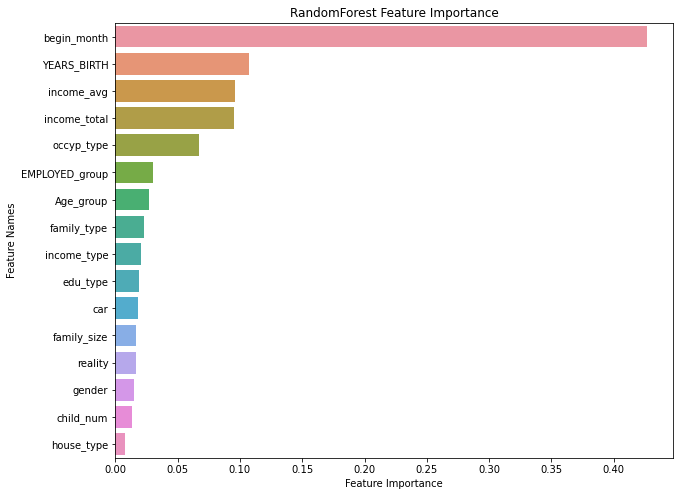

In [36]:
plot_feature_importance(model_cat.feature_importances_,X_test.columns,'RandomForest')